In [1]:
from Vaults_lib import *
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import re

%matplotlib widget

In [10]:
Data = pd.read_csv('./data/vaultstvl_new.csv')

In [32]:
labels = []
price_labels = []

vaults = [
    'MIM',
    'FRAX',
    'USDN',
    'alUSD',
    'mUSD',
    #'MIMUST'
]

for i, val in enumerate(vaults):
    vaults[i] += ' Price'

for name in Data.columns:
    if (name in vaults): #we need only prices
        label = name.replace(' Price', '')
        labels.append(label)
        price_labels.append(name)

Prices = pd.DataFrame()
Prices['Block'] = Data['Block']
Prices = Prices.merge(Data.loc[:, ['Block', 'Date'] + vaults], how='outer')
Prices['Date'] = pd.to_datetime(Prices['Date'])
Prices = Prices.loc[Prices['Date'] > pd.to_datetime("09-05-2021"), :]
Prices.head()

,Block,Date,MIM Price,FRAX Price,USDN Price,alUSD Price,mUSD Price
59,13165046,2021-09-05 09:58:56,1.0019,1.0410,1.0772,1.0416,1.0395
60,13171507,2021-09-06 09:59:11,1.0019,1.0410,1.0777,1.0416,1.0395
61,13177968,2021-09-07 09:54:07,1.0020,1.0410,1.0782,1.0423,1.0395
62,13184429,2021-09-08 09:56:15,1.0020,1.0421,1.0794,1.0423,1.0395
63,13190890,2021-09-09 10:04:36,1.0020,1.0421,1.0798,1.0431,1.0395


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
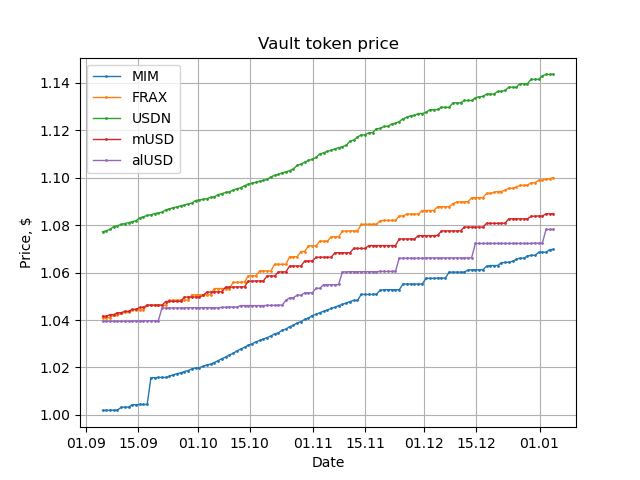

In [33]:
%matplotlib widget

for col in Prices.columns:
    if ('price' in col.lower()):
        plt.plot(Prices['Date'], Prices[col], lw=1, marker='.', markersize=2)

plt.grid()
plt.title('Vault token price')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend(labels)

myFmt = mdates.DateFormatter('%d.%m')
plt.gca().xaxis.set_major_formatter(myFmt)


In [34]:
def calc_price_velocity(prices, step, dates=None):

    if not(isinstance(step, int) or (step <= 0)):
        print('What the fuck?')
        return

    lp = len(prices)

    if (dates):

        ld = len(dates)
        
        if (lp != ld):
            print('What the fuck?')
            return

    l = lp

    velocities = np.zeros(l)

    for i in range(step, l):
        D = (prices[i] - prices[i-step])/step
        velocities[i] = D
    
    return velocities

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
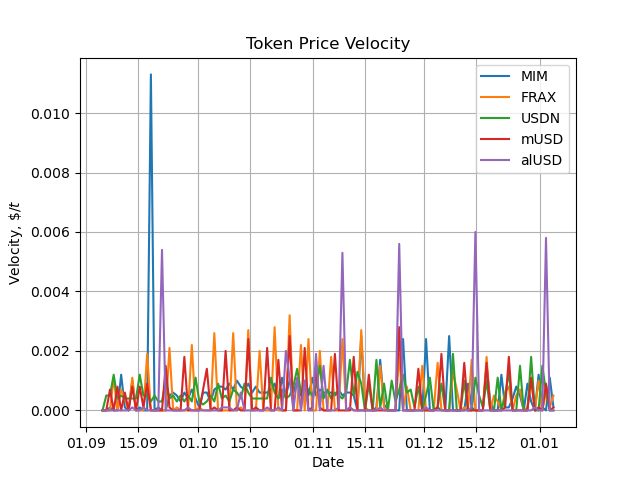

In [36]:

%matplotlib widget

Velocities = deepcopy(Prices.iloc[:, 0:2])

vel_labels = []

for label in labels:
    vel_labels.append(label + ' Price Velocity')

Velocities = Velocities.reindex(columns = list(Velocities.columns) + list(vel_labels), fill_value=0)
Velocities

for i in range(2, len(Velocities.columns)):

    Velocities.iloc[:, i] = calc_price_velocity(Prices.iloc[:, i].to_numpy(), 1)

for label in vel_labels:
    plt.plot(Velocities['Date'], Velocities[label])

plt.legend(labels)
plt.grid()
plt.title('Token Price Velocity')
plt.xlabel('Date')
plt.ylabel('Velocity, $\\$/t$')

myFmt = mdates.DateFormatter('%d.%m')
plt.gca().xaxis.set_major_formatter(myFmt)


In [37]:
def calc_shares_price_velocity(velocities_):

    if (isinstance(velocities_, np.ndarray)):
        velocities = velocities_
    elif (isinstance(velocities_, list)):
        velocities = np.array(velocities_)
    total_velocity = sum(velocities)
    shares = velocities/total_velocity

    return shares


In [38]:
Velocities.head(5)

,Block,Date,MIM Price Velocity,FRAX Price Velocity,USDN Price Velocity,mUSD Price Velocity,alUSD Price Velocity
59,13165046,2021-09-05 09:58:56,0.0000,0.0000,0.0000,0.0000,0.0
60,13171507,2021-09-06 09:59:11,0.0000,0.0000,0.0005,0.0000,0.0
61,13177968,2021-09-07 09:54:07,0.0001,0.0000,0.0005,0.0007,0.0
62,13184429,2021-09-08 09:56:15,0.0000,0.0011,0.0012,0.0000,0.0
63,13190890,2021-09-09 10:04:36,0.0000,0.0000,0.0004,0.0008,0.0


C:\Users\backg\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\backg\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
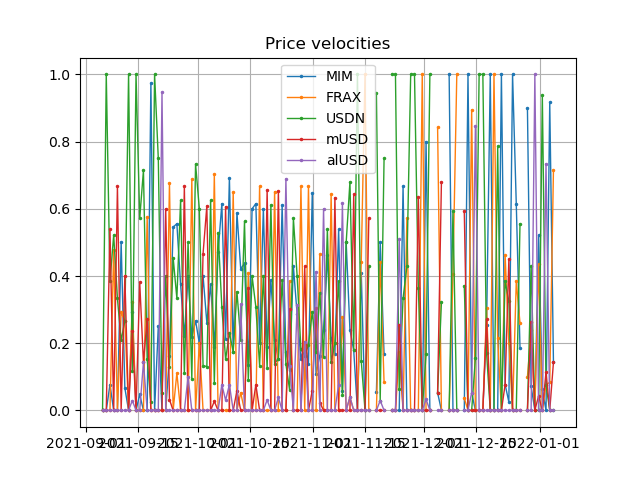

In [39]:
%matplotlib widget

PoolShares = pd.DataFrame(deepcopy(Velocities['Date']))

ps_labels = [label + ' Share' for label in labels]

PoolShares = PoolShares.reindex(columns = list(PoolShares.columns) + list(ps_labels), fill_value=0)

for idx, day in enumerate(PoolShares['Date']):

    if (idx >= 1):
        vels = Velocities.iloc[idx, 2:].to_numpy()
        PoolShares.iloc[idx, 1:] = calc_shares_price_velocity(vels)

PoolShares.head()

for c in PoolShares.iloc[:, 1:].columns:
    plt.plot(PoolShares['Date'], PoolShares[c], lw=1, marker='.', markersize=3)

plt.title('Price velocities')
plt.grid()
plt.legend(labels)

In [40]:
funds = np.zeros(len(labels))

for i in range(len(labels)):
    funds[i] = 300000

money = np.zeros((len(Prices), len(labels)), dtype=float)

## 1. HODL

This strategy is just HODLing vault tokens and relying on their growth due to comission accumulation

In [41]:
#1. HODL
print('1. HODL Strategy:')
init_TVL = sum(funds*Prices[price_labels].iloc[1, :])
final_TVL = sum(funds*Prices[price_labels].iloc[-1, :])
gain = final_TVL - init_TVL
gain_yearly = gain/len(Prices)*365
APR = gain_yearly/init_TVL*100

print('Initial TVL: ${:0,.3f}'.format(init_TVL))
print('Final TVL: {:0,.3f}'.format(final_TVL))
print('Gain: ${:0,.3f} over {:0,.3f} days === {:0,.3f}% APR'.format(gain, len(Prices), APR))


1. HODL Strategy:
Initial TVL: $1,560,510.000
Final TVL: 1,642,980.000
Gain: $82,470.000 over 121.000 days === 15.942% APR


## 2. Price Velocity Drop
After each jump in token price, we rebalance the asset basket to minimize the share of the token that recently jumped in price.

Suppose we have $n$ different tokens with price at the $i^{th}$ timestep  $P_{i}^{(k)}$

For each step we calculate the price jump relative to other tokens like this:

$$
\delta P_{i}^{(k)} = \frac{P_{i}^{(k)} - P_{i-1}^{(k)}}{P_{i-1}^{(k)}}\\


\delta P_{i_{relative}}^{(k)} = \frac{\delta P_{i}^{(k)}}{\sum\limits_{j=1}^{n} \delta P_{i}^{(j)}}
$$

Assuming that we sell $100\%$ of the token that increased in the price most, we sell another tokens respectively to their relative price jump. Other tokens are replenished in equal amounts. If we denote the amount of token $k$ in the basket as $T^{(k)}$, that can be written as:

$$
\delta T_{i}^{(k)} = -\frac{\delta P_{i_{relative}}^{(k)}}{\max\limits_{j} \big \{ \delta P_{i_{relative}}^{(j)} \big \}} T_{i}^{(k)}
$$

In [42]:
%matplotlib widget

n = len(labels) #number of Vaults
d = len(Prices) #number of days

funds = np.zeros((d, n), dtype=np.float64)
for i in range(len(labels)):
    funds[0][i] = 300000

money = np.zeros((d, n), dtype=np.float64)
prices = Prices[price_labels].to_numpy()
dates = Prices.loc[:, 'Date'].to_numpy()

delta = 1 #number of steps to average price velocity

for i in range(1, d):
    
    funds[i] = funds[i-1]

    jumps = np.zeros(n, dtype=np.float64)
    for j in range(n):
        jumps[j] = ((prices[i][j] - prices[i-1][j])/delta)/prices[i-1][j] #relative jump in price

    #shifting and stretching so that jumps are from -1 to 1
    jumps = jumps - np.mean((max(jumps), min(jumps)))
    jumps = jumps / max(abs(jumps))

    relative_jumps = jumps

    '''relative_jumps = np.zeros(n, dtype=np.float64)
    for j in range(n):
        relative_jumps[j] = jumps[j]/total_jump
        
    relative_jumps = relative_jumps/max(relative_jumps) #this should give us relative amounts to sell
    print("relative jumps: ", relative_jumps)
    print('\n')
    '''

    cash = 0
    counter = 0 #we count the number of tokens we sold

    for k in range(n):
        if (relative_jumps[k] > 0):
            token_sold = relative_jumps[k]*funds[i][k]
            cash += token_sold * prices[i][k]
            funds[i][k] -= token_sold
            counter += 1

    sum_negative_jumps = 0
    for k in range(n):
        if (relative_jumps[k] <= 0):
            sum_negative_jumps += relative_jumps[k]

    for k in range(n):
        if (relative_jumps[k] <= 0):
            token_bought = cash * relative_jumps[k]/sum_negative_jumps/prices[i][k]
            funds[i][k] += token_bought

C:\Users\backg\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [43]:
init_TVL2 = sum(funds[0] * prices[0])
final_TVL2 = sum(funds[-1] * prices[-1])
gain2 = final_TVL2 - init_TVL2
gain_yearly2 = gain2/d*365
APR2 = gain_yearly2/init_TVL2*100

print('Initial TVL: ${:0,.3f}'.format(init_TVL2))
print('Final TVL: ${:0,.3f}'.format(final_TVL2))
print('Gain: ${:0,.3f} over {:d} days === {:0,.3f}% APR'.format(gain2, d, APR2))

Initial TVL: $1,560,360.000
Final TVL: $1,650,643.245
Gain: $90,283.245 over 121 days === 17.454% APR


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
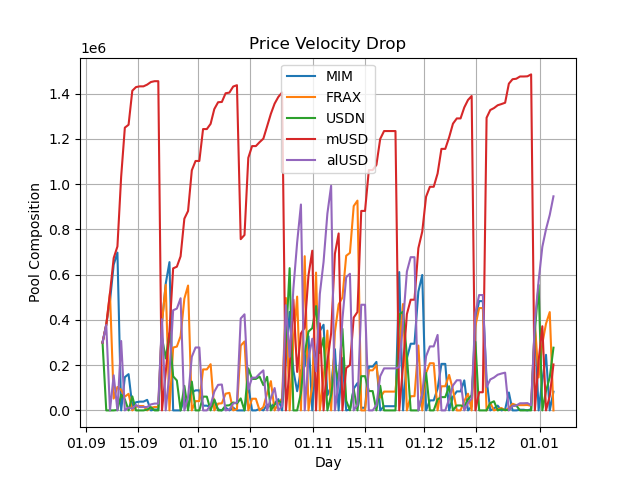

In [44]:
%matplotlib widget

for k in range(n):
    plt.plot(dates, funds[:, k])

plt.title('Price Velocity Drop')
plt.grid()
plt.xlabel('Day')
plt.ylabel('Pool Composition')
plt.legend(labels)

myFmt = mdates.DateFormatter('%d.%m')
plt.gca().xaxis.set_major_formatter(myFmt)

## 3. Slope Optimization

In this strategy we will try to use differently sized slopes of the price history in order to generalize the behaviour of the vault. Each slope will adjust the balance of the portfolio to maximize the income yet retaining some level of diversifitaction.

In [45]:
from scipy.stats import linregress as linreg
from scipy.fft import fft, ifft
plt.ion()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
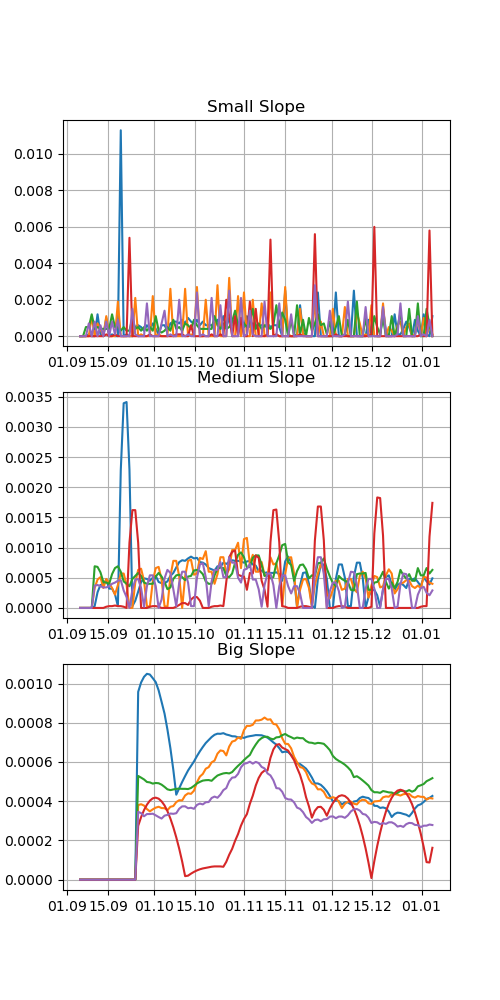

In [46]:
%matplotlib widget

n = len(labels)
days = Prices['Date'].to_numpy()
d = len(days)
days_i = np.arange(d)

prices
price_slope_small = np.zeros((d, n), dtype=np.float64)
price_slope_medium = np.zeros((d, n), dtype=np.float64)
price_slope_big = np.zeros((d, n), dtype=np.float64)

delta_small = 2
delta_medium = 5
delta_big = 20

for i in range(d):

    if (i >= delta_small):
        for k in range(n):
            price_slope_small[i][k] = linreg(days_i[i-delta_small:i], prices[i-delta_small:i, k])[0]

    if (i >= delta_medium):
        for k in range(n):
            price_slope_medium[i][k] = linreg(days_i[i-delta_medium:i], prices[i-delta_medium:i, k])[0]
    '''elif (i >= 2):            
        for k in range(n):
            price_slope_medium[i][k] = linreg(days_i[i-i:i], prices[i-i:i, k])[0]'''


    if (i >= delta_big):
        for k in range(n):
            price_slope_big[i][k] = linreg(days_i[i-delta_big:i], prices[i-delta_big:i, k])[0]
    '''elif (i >= 2):
        for k in range(n):
            price_slope_big[i][k] = linreg(days_i[i-i:i], prices[i-i:i, k])[0]'''


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

for i in range(n):
    ax1.plot(days, price_slope_small[:, i])
    ax2.plot(days, price_slope_medium[:, i])
    ax3.plot(days, price_slope_big[:, i])

ax1.set_title('Small Slope')
ax2.set_title('Medium Slope')
ax3.set_title('Big Slope')

fig.set_size_inches(5, 10)

myFmt = mdates.DateFormatter('%d.%m')
ax1.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_formatter(myFmt)
ax3.xaxis.set_major_formatter(myFmt)

ax1.grid()
ax2.grid()
ax3.grid()


In [47]:
import numpy as np
from scipy.optimize import minimize
from numba import jit

In [48]:

d = len(dates)
n = len(labels)
funds = np.zeros((d, n), dtype=np.float64)
for i in range(len(labels)):
    funds[0][i] = 300000

money = np.zeros((d, n), dtype=np.float64)
prices = Prices[price_labels].to_numpy()
dates = Prices.loc[:, 'Date'].to_numpy()

def str3(coefs, slopes, funds, prices, d):

    #print(coefs)
    i = 1
    while (i < d):

        funds[i] = funds[i-1]

        total_money = np.dot(funds[i], prices[i])
        '''sslope_slice = price_slope_small[:i]
        mslope_slice = price_slope_medium[:i]
        bslope_slice = price_slope_big[:i]'''
        a = price_slope_small[i]
        b = price_slope_medium[i]
        c = price_slope_big[i]

        #da = a - price_slope_small[i-1]
        #db = b - price_slope_medium[i-1]
        #dc = c - price_slope_big[i-1]

        slopes[0] = a
        slopes[1] = b
        slopes[2] = c
        #dslopes = np.array([da, db, dc])

        #slopes = np.matrix(slopes)
        #dslopes = np.matrix(dslopes)
        '''for i in range(dslopes.shape[0]):
            for j in range(dslopes.shape[1]):
                if (dslopes[i][j] == 0):
                    dslopes[i][j] = 1'''

        #slopes = np.divide(slopes, dslopes)

        #coefs = np.array([1, 1, 1])
        coefs = np.divide(coefs, np.sum(coefs))

        weights = np.dot(coefs.T, slopes)
        #weights = np.squeeze(np.asarray(weights))

        if (np.sum(weights) == 0):
            weights += 1

        weights = np.divide(weights, sum(weights))

        funds[i] = np.divide(total_money * weights, prices[i])

        i += 1

    return np.sum(funds[-1] * prices[-1]) - np.sum(funds[0] * prices[0])


#opt = minimize(str3, x0 = [10, 100, 100])


In [49]:
default_coefs = np.array([1, 1, 1], dtype=np.float64)
slopes = np.zeros((3, 5), dtype=np.float64)

%time str3(default_coefs, slopes, funds, prices, d)

str3_jit = jit()(str3)

%time str3_jit(default_coefs, slopes, funds, prices, d)


Wall time: 17.3 ms


C:\Users\backg\AppData\Local\Temp/ipykernel_17060/3664089510.py:19: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  total_money = np.dot(funds[i], prices[i])


Wall time: 6.57 s


74730.40491093439

In [50]:
default_coefs = np.array([1, 1, 1], dtype=np.float64)
slopes = np.zeros((3, 5), dtype=np.float64)

%time str3_jit(default_coefs, slopes, funds, prices, d)

Wall time: 0 ns


74730.40491093439

In [51]:
#optimization by hand:
results = np.zeros((100*100*100, 4))

counter = 0
for i in range(1, 101):
    print(i)
    for j in range(1, 101):
        for k in range(1, 101):
            slopes = np.zeros((3, 5), dtype=np.float64)
            coefs = np.array([i, j, k], dtype=np.float64)
            res = str3_jit(coefs, slopes, funds, prices, d)
            results[counter] = np.append(coefs, res)
            counter += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [52]:
#print(np.max(results[:, 3]))
coefs = results[2799][:3]
slopes = np.zeros((3, 5), dtype=np.float64)
gain33 = str3_jit(coefs, slopes, funds, prices, d)
init_TVL33 = np.dot(funds[0], prices[0])
final_TVL33 = np.dot(funds[-1], prices[-1])
gain_check = init_TVL33 - final_TVL33
APR33 = gain33 / final_TVL33 / d * 365


print('Initial TVL: ${:0,.3f}'.format(init_TVL33))
print('Final TVL: ${:0,.3f}'.format(final_TVL33))
print('Gain: ${:0,.3f} over {:d} days === {:0,.3f}% APR'.format(gain33, d, APR33))

Initial TVL: $1,560,360.000
Final TVL: $1,643,097.785
Gain: $82,737.785 over 121 days === 0.152% APR


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
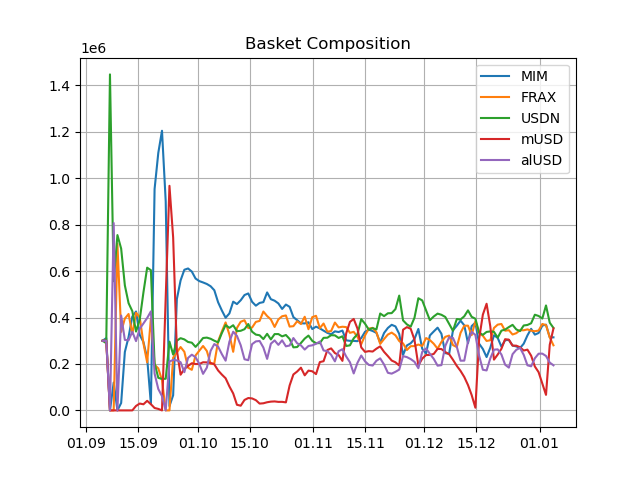

In [53]:
%matplotlib widget

for i in range(len(labels)):
    plt.plot(dates, funds[:, i])

plt.title('Basket Composition')
plt.grid()
plt.legend(labels)
myFmt = mdates.DateFormatter('%d.%m')
plt.gca().xaxis.set_major_formatter(myFmt)

## 4. ALL IN

As simple it sounds

In [45]:
#1. HODL
print('1. ALL IN:')
funds = 1.5e6

init_TVL = funds*Prices[price_labels].iloc[1, :].to_numpy()
final_TVL = funds*Prices[price_labels].iloc[-1, :].to_numpy()
gain = final_TVL - init_TVL
gain_yearly = np.divide(gain, len(Prices)) * 365
APR = np.divide(gain_yearly, init_TVL) * 100

print('Initial TVL: ${}'.format(init_TVL))
print('Final TVL: {}'.format(final_TVL))
print('Gain: ${} over {:0,.3f} days === {} APR'.format(gain, len(Prices), APR))
labels

1. ALL IN:
Initial TVL: $[1502850. 1561500. 1616700. 1562400. 1559250.]
Final TVL: [1549200. 1591050. 1648950. 1587900. 1569300.]
Gain: $[46350. 29550. 32250. 25500. 10050.] over 45.000 days === [25.01580331 15.34955705 16.18007876 13.23818058  5.22794078] APR


['MIM', 'FRAX', 'USDN', 'alUSD', 'mUSD']

C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Pyt

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
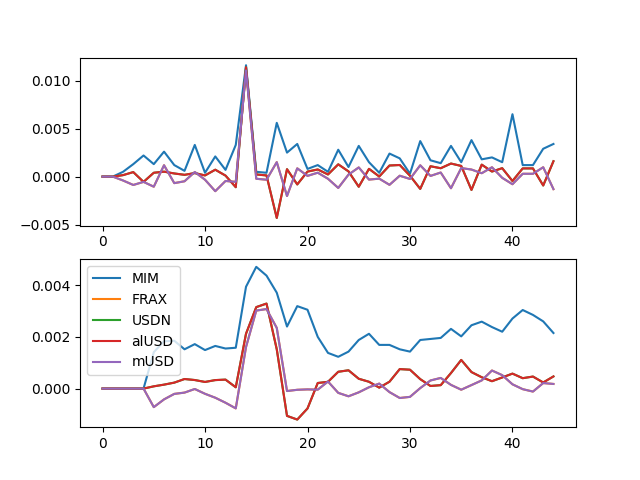

In [46]:
%matplotlib widget

small_fft = fft(price_slope_small)
medium_fft = fft(price_slope_medium)

fig, (ax1, ax2) = plt.subplots(2, 1)
for i in range(n):
    ax1.plot(small_fft[:, i])
    ax2.plot(medium_fft[:, i])



plt.legend(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
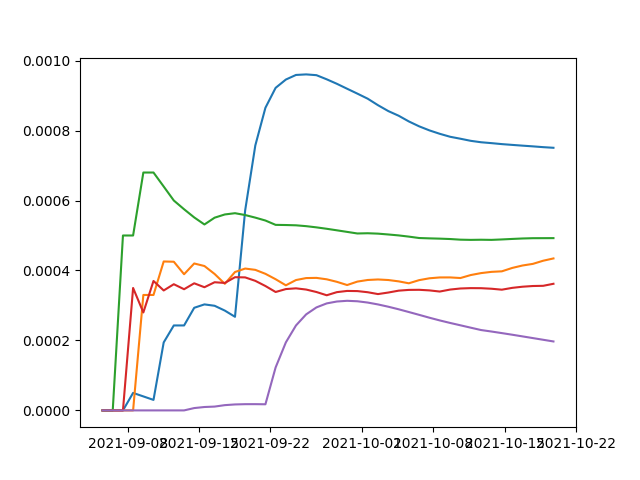

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
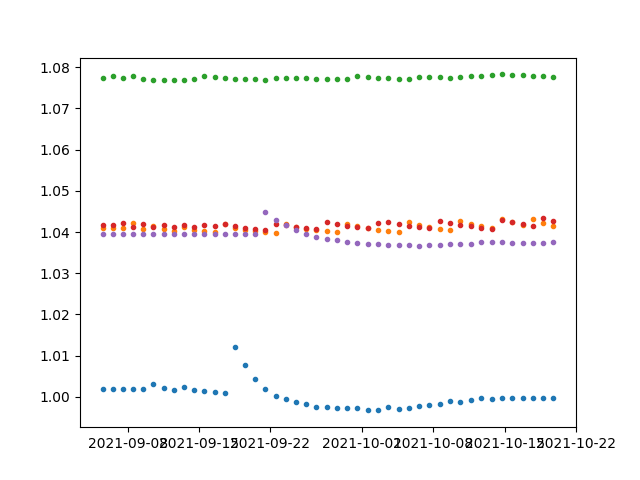

In [47]:
%matplotlib widget

d = len(days)
n = len(labels)

days_i = np.arange(d)


big_sloppa = np.zeros((d, n), dtype=np.float64)
delta_thicc = 30

for i in range(d):
    if (i >= 2):
        for k in range(n):
            big_sloppa[i, k] = linreg(days_i[i - i:i], prices[i-i:i, k])[0]


for k in range(n):
    plt.plot(days, big_sloppa[:, k])

plt.figure()

voennoe_prestuplenie = np.zeros((d, n))
for k in range(n):
    voennoe_prestuplenie[:, k] = prices[:, k] - big_sloppa[:, k] * days_i
    plt.plot(days, voennoe_prestuplenie[:, k], lw=0, marker='.')

C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
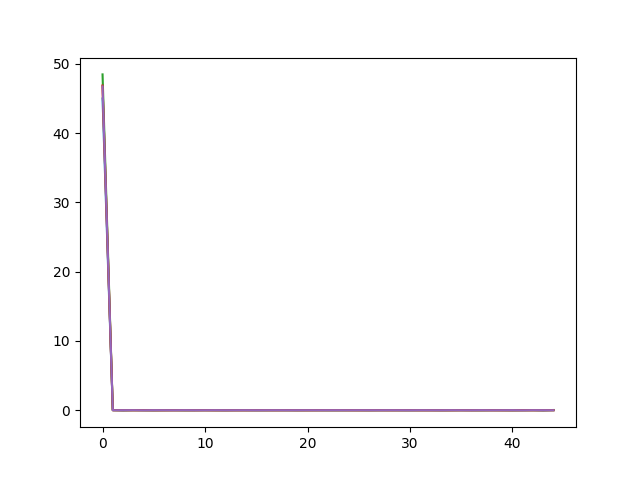

In [48]:
%matplotlib widget

for k in range(n):
    plt.plot(days_i, fft(voennoe_prestuplenie[:, k]))

C:\Program Files\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
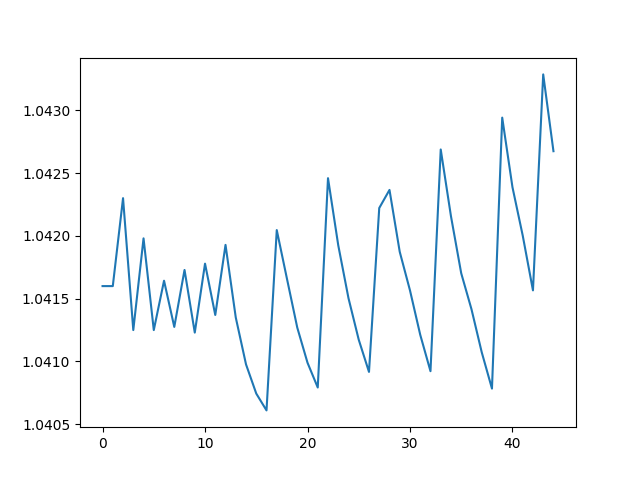

In [49]:
%matplotlib widget
plt.plot(ifft(fft(voennoe_prestuplenie[:, 3])))